In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf


In [2]:
sps_parameters = np.load("training_data/sps_parameters_150600000.npy")

In [3]:
photometry = np.load("training_data/photometry_150600000.npy")

In [26]:
nsamples = 1000000
full_params = sps_parameters[:nsamples, :]
full_data = photometry[:nsamples, :]
full_redshifts = full_params[:, 0]

In [27]:
rmin = 20 #what should this be?
rmax = 25 #what should this be?
selected_indexes = np.where((full_data[:, 2] > rmin) & (full_data[:, 2] < rmax) )[0]
params = full_params[selected_indexes, :]
data = full_data[selected_indexes, :]
redshifts = full_redshifts[selected_indexes]
labels = np.zeros_like(redshifts)

(array([1033., 1028.,  958.,  991.,  931.,  871.,  872.,  858.,  753.,
         776.]),
 array([2.50013786, 2.60010843, 2.700079  , 2.80004958, 2.90002015,
        2.99999072, 3.09996129, 3.19993186, 3.29990244, 3.39987301,
        3.49984358]),
 <BarContainer object of 10 artists>)

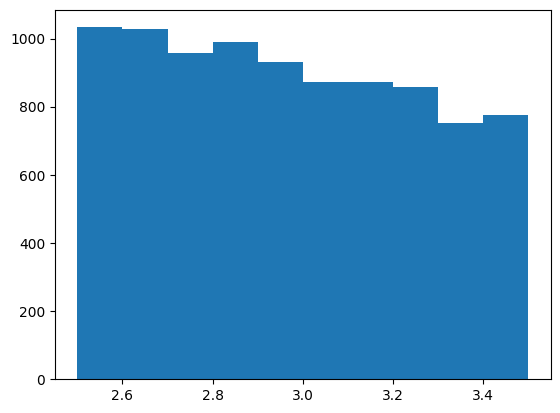

In [28]:
z_min = 2.5
z_max = 3.5
u_indexes = np.where((redshifts > z_min) & (redshifts < z_max) )[0]#& (data[:, 0] - data[:, 1] > 0.0))[0]
u_params = params[u_indexes, :]
u_data = data[u_indexes, :]
labels[u_indexes] = 1
plt.hist(u_params[:, 0])

In [29]:
# calculate colours of a set of photometry
def calculate_colours(photometry):
    
    photo1 = photometry[:,:-1]
    photo2 = photometry[:,1:]
    colours = photo1 - photo2

    return colours

In [31]:
#From photometry want to predict label
print(data.shape)
features = calculate_colours(data)


dataset = tf.data.Dataset.from_tensor_slices((data, labels))

validation_split = 0.9
train_size = int(validation_split * data.shape[0])
test_size = data.shape[0] - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(batch_size=1000)

(84125, 6)


In [32]:
depth = 32
model = tfdf.keras.RandomForestModel(max_depth=depth, verbose=2)
model.fit(train_dataset)

Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmphno8_0k2 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None, 6), dtype=float64)
Label: Tensor("data_1:0", shape=(None,), dtype=float64)
Weights: None
Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(None,) dtype=float32>), 'data:0.4': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_4:0' shape=(None,) dtype=float32>), 'data:0.5': 

In [33]:
model.save("saved_models/test_"+str(depth)+"_"+str(data.shape))

INFO:tensorflow:Assets written to: saved_models/test_32_(84125, 6)/assets


INFO:tensorflow:Assets written to: saved_models/test_32_(84125, 6)/assets


In [34]:
model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_dataset.batch(batch_size=1000), return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

9/9 [==============================] - 2s 35ms/step - loss: 0.0000e+00 - accuracy: 0.9522

loss: 0.0000
accuracy: 0.9522


In [35]:
print(model.make_inspector().extract_tree(1))

(data:0.5 >= 19.915264129638672; miss=True, score=0.017638662829995155)
    ├─(pos)─ (data:0.5 >= 22.69759750366211; miss=False, score=0.008688759990036488)
    │        ├─(pos)─ (data:0.4 >= 23.757461547851562; miss=False, score=0.008429576642811298)
    │        │        ├─(pos)─ (data:0.0 >= 26.369571685791016; miss=False, score=0.09155621379613876)
    │        │        │    ...
    │        │        └─(neg)─ (data:0.2 >= 24.135465621948242; miss=False, score=0.021737180650234222)
    │        │             ...
    │        └─(neg)─ (data:0.1 >= 24.486223220825195; miss=True, score=0.008114888332784176)
    │                 ├─(pos)─ (data:0.4 >= 21.92107391357422; miss=False, score=0.014788725413382053)
    │                 │    ...
    │                 └─(neg)─ (data:0.0 >= 25.858238220214844; miss=True, score=0.033135708421468735)
    │                      ...
    └─(neg)─ (data:0.4 >= 19.359893798828125; miss=True, score=0.009121759794652462)
             ├─(pos)─ (data:0.2 

In [36]:
predicted_labels = model.predict(test_dataset.batch(batch_size=1000))

9/9 [==============================] - 0s 31ms/step


In [37]:
predicted_labels[:, 0].max()

0.99999917

tf.Tensor(
[[7541    1]
 [ 748  123]], shape=(2, 2), dtype=int32)
efficency(%):  14.121699196326063
purity(%):  99.19354838709677
interloper fraction(%):  0.0


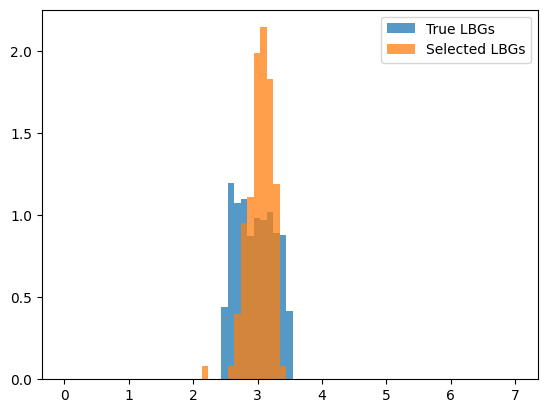

In [49]:
confidence_level = 0.95 #hyperparameter(ideal value depends on survey size? The larger your initial set of galaxies, the lower your efficency can be)
predictions = predicted_labels[:, 0]
predicted_labels_at_confidence = np.where(predictions > confidence_level, 1.0, 0.0)
cmatrix = tf.math.confusion_matrix(labels[train_size:], predicted_labels_at_confidence)

print(cmatrix)
# TN FP
# FN TP

z_bins = np.linspace(0.0, 7.0, 70)

test_set_redshifts = redshifts[train_size:]
test_set_lbgs = test_set_redshifts[np.where((test_set_redshifts > 2.5) & (test_set_redshifts < 3.5) )[0]]

selected_lbgs = test_set_redshifts[np.where(predicted_labels_at_confidence == 1.0)[0]]

plt.hist(test_set_lbgs, bins=z_bins, label="True LBGs", density=True, alpha=0.75)
plt.hist(selected_lbgs, bins=z_bins, label="Selected LBGs", density=True, alpha=0.75)
plt.legend()

ninterlopers =  (np.where(selected_lbgs < 1.5)[0]).shape[0]

print("efficency(%): ", float(((cmatrix[1, 1])/test_set_lbgs.shape[0])*100))
print("purity(%): ", float((cmatrix[1, 1]/(cmatrix[0,1]+cmatrix[1, 1]))*100)) #of all positives - which are truly lbgs?
print("interloper fraction(%): ", (ninterlopers/selected_lbgs.shape[0])*100) #of all positives - which are truly lbgs?